<a href="https://colab.research.google.com/github/Munazza-Farees/NITW-SIP2025-Project/blob/main/WS_GTC_FL_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install numpy pandas torch sklearn --quiet
!pip install kymatio --quiet

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [52]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from kymatio.torch import Scattering1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [53]:
URL = "/content/drive/MyDrive/Datasets/crosslayer_ldos_dataset_filtered2.csv"
data = pd.read_csv(URL)

In [54]:
# Select relevant features for wavelet scattering (time-series and statistical)
features = [
    'packet_rate', 'byte_rate', 'inter_arrival_mean', 'inter_arrival_std',
    'flow_duration', 'length_mean', 'length_std', 'packet_size_std',
    'tcp_syn_count', 'tcp_ack_count', 'tcp_flag_entropy', 'rtt_mean', 'rtt_std',
    'payload_entropy', 'source_entropy'
]

X = data[features].values
y = data['label'].values

X = np.nan_to_num(X, nan=np.mean(X, axis=0))

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [56]:
# Set up Wavelet Scattering
J = 4    # Invariance scale
Q = 8     # Quality factor (number of wavelets per octave)
T = X_train.shape[1]      # Length of input signal (number of features)
scattering = Scattering1D(J, T, Q)

X_train_scattering = scattering(X_train)
X_test_scattering = scattering(X_test)

X_train_scattering = X_train_scattering.view(X_train_scattering.size(0), 1, -1)
X_test_scattering = X_test_scattering.view(X_test_scattering.size(0), 1, -1)

/usr/local/lib/python3.11/dist-packages/kymatio/scattering1d/filter_bank.py:218: UserWarning: Signal support is too small to avoid border effects
  warnings.warn('Signal support is too small to avoid border effects')


In [57]:
# 3. Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Weight for positive class (attack)
        self.gamma = gamma  # Focusing parameter
        self.reduction = reduction
    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)  # pt = e^(-CE_loss), probability of true class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss
# Explanation:
# - Defines Focal Loss with α=0.75 (prioritizes attack class) and γ=2 (focuses on hard examples).
# - Computes CrossEntropyLoss per sample, then applies focal term (1 - pt)^γ to scale loss.
# - Supports reduction (mean or sum) for batch processing.

# 4. Define Gated Temporal Convolutional Layer
class GatedConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(GatedConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.gate = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    def forward(self, x):
        conv_output = self.conv(x)  # Feature extraction
        gate_output = self.sigmoid(self.gate(x))  # Gating weights
        output = conv_output * gate_output  # Element-wise multiplication
        return self.relu(output)
# Explanation:
# - Defines a gated convolutional block with two parallel Conv1d layers: one for features, one for gates.
# - The gate layer uses sigmoid to produce weights [0, 1], which modulate the feature output.
# - ReLU activation ensures non-linearity after gating.

# 5. Define GTCN Model
class LDOS_GTCN(nn.Module):
    def __init__(self):
        super(LDOS_GTCN, self).__init__()
        self.gated_conv1 = GatedConvBlock(in_channels=1, out_channels=32, kernel_size=3)
        self.gated_conv2 = GatedConvBlock(in_channels=32, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        # Calculate output size after convolutions and pooling
        sequence_length = X_train_scattering.shape[2]  # Initial sequence length
        sequence_length = sequence_length // 2  # After first pooling
        sequence_length = sequence_length // 2  # After second pooling
        self.fc_input_size = 64 * sequence_length
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: normal, attack
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.pool(self.gated_conv1(x))
        x = self.pool(self.gated_conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# Explanation:
# - Defines a GTCN with two gated convolutional blocks (32 and 64 channels).
# - Each block is followed by max-pooling to reduce sequence length.
# - Computes fc_input_size based on the sequence length after convolutions and pooling.
# - Uses two fully connected layers to predict normal or attack.

# 6. Initialize model, loss function, and optimizer
model = LDOS_GTCN()
criterion = FocalLoss(alpha=0.75, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Explanation:
# - Initializes the GTCN model.
# - Uses Focal Loss with α=0.75 to prioritize LDoS attacks and γ=2 for hard examples.
# - Uses Adam optimizer with learning rate of 0.001.

# 7. Train the model
num_epochs = 20
batch_size = 32
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train_scattering), batch_size):
        inputs = X_train_scattering[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute focal loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
# Explanation:
# - Trains model for 20 epochs with batch size of 32.
# - Processes scattering features, computes Focal Loss, and updates weights via backpropagation.
# - Prints loss to monitor training progress.

# 8. Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_scattering)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).float().mean()
    print(f'Test Accuracy: {accuracy.item()*100:.2f}%')
# Explanation:
# - Evaluates model on test data, computing predictions and accuracy.
# - Prints accuracy as a percentage.

# 9. Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Models/gtcn_model.pth')
# Explanation: Saves trained model weights for future use or SDN deployment.

Epoch 1, Loss: 0.1259
Epoch 2, Loss: 0.1145
Epoch 3, Loss: 0.0866
Epoch 4, Loss: 0.0824
Epoch 5, Loss: 0.0785
Epoch 6, Loss: 0.0667
Epoch 7, Loss: 0.0497
Epoch 8, Loss: 0.0390
Epoch 9, Loss: 0.0342
Epoch 10, Loss: 0.0310
Epoch 11, Loss: 0.0271
Epoch 12, Loss: 0.0214
Epoch 13, Loss: 0.0181
Epoch 14, Loss: 0.0156
Epoch 15, Loss: 0.0139
Epoch 16, Loss: 0.0120
Epoch 17, Loss: 0.0108
Epoch 18, Loss: 0.0093
Epoch 19, Loss: 0.0080
Epoch 20, Loss: 0.0070
Test Accuracy: 99.16%


In [58]:
from sklearn.metrics import classification_report

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(X_test_scattering)
    _, predicted = torch.max(outputs, 1)
    y_true = y_test.numpy()
    y_pred = predicted.numpy()

# Print classification report
print(classification_report(y_true, y_pred, target_names=['Normal', 'Attack']))
# Explanation:
# - Computes model predictions on test data.
# - Generates a classification report with metrics for normal and attack classes.
# - Prints the report to the console.

              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       175
      Attack       1.00      0.98      0.99       182

    accuracy                           0.99       357
   macro avg       0.99      0.99      0.99       357
weighted avg       0.99      0.99      0.99       357



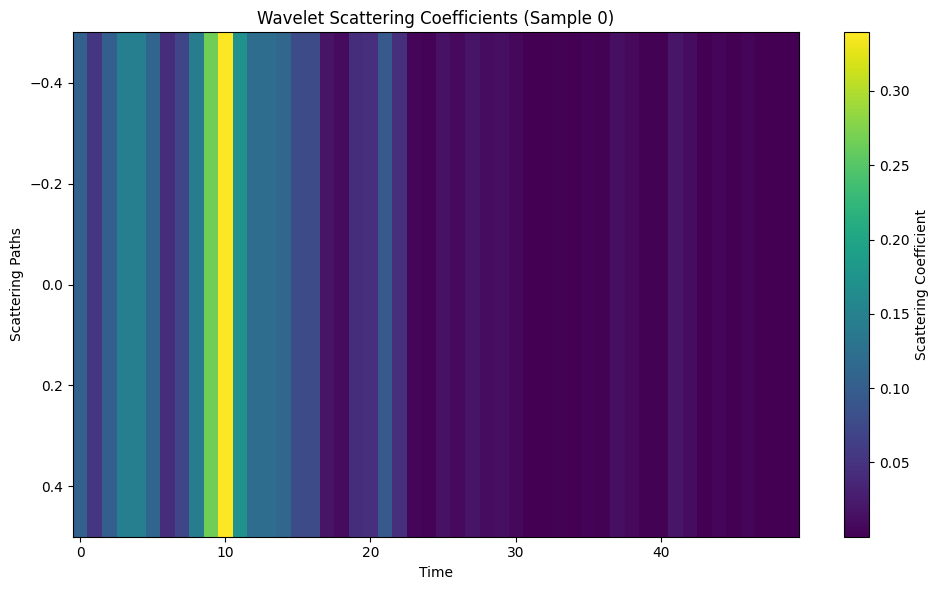

In [59]:
import matplotlib.pyplot as plt
import torch

# Select a sample from training data
sample_idx = 0
scattering_sample = X_train_scattering[sample_idx].squeeze(0).numpy()  # Shape: [num_paths * time]

# Reshape scattering coefficients to 2D
scattering_sample = scattering_sample.reshape(1, -1)


# Plot scattering coefficients
plt.figure(figsize=(10, 6))
plt.imshow(scattering_sample, aspect='auto', cmap='viridis')
plt.colorbar(label='Scattering Coefficient')
plt.title(f'Wavelet Scattering Coefficients (Sample {sample_idx})')
plt.xlabel('Time')
plt.ylabel('Scattering Paths')
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Models/scattering_plot.png')
plt.show()
# Explanation:
# - Selects a sample from X_train_scattering and converts to numpy.
# - Reshapes scattering coefficients to a 2D array for plotting.
# - Plots a 2D heatmap of scattering coefficients, showing time-frequency patterns.
# - Saves the plot to a file.

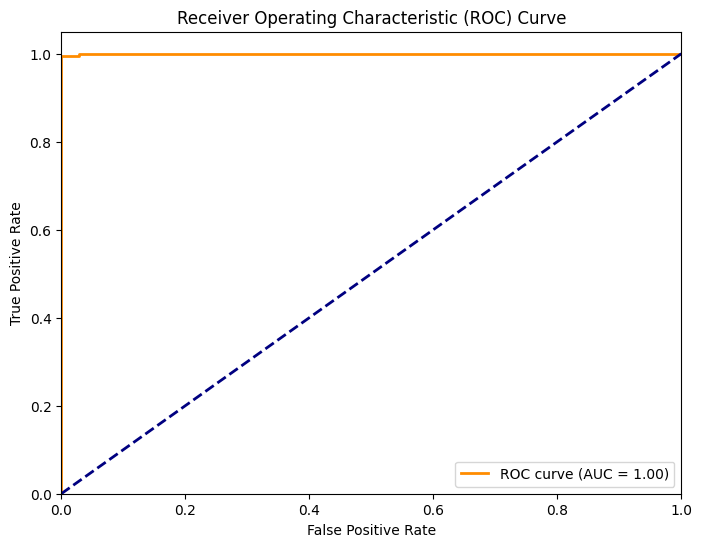

In [60]:
from sklearn.metrics import roc_curve, auc

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(X_test_scattering)
    probs = torch.softmax(outputs, dim=1)[:, 1].numpy()  # Probability for attack class
    y_true = y_test.numpy()

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
# plt.savefig('/content/drive/MyDrive/Models/roc_curve.png')
plt.show()
# Explanation:
# - Computes softmax probabilities for the attack class.
# - Calculates false positive rate (FPR) and true positive rate (TPR) using roc_curve.
# - Plots ROC curve with AUC score and saves to a file.

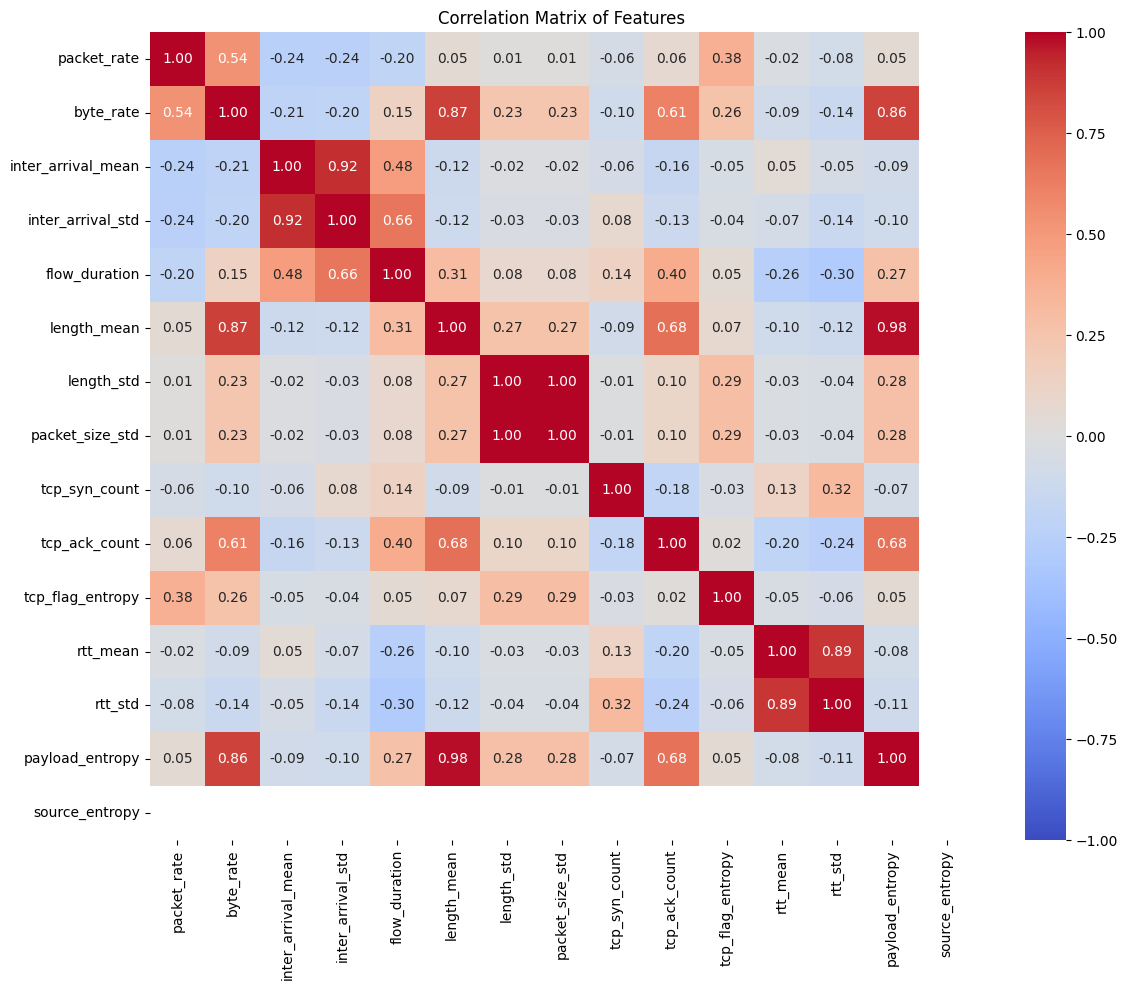

In [61]:
import seaborn as sns

# Create DataFrame with selected features
features = [
    'packet_rate', 'byte_rate', 'inter_arrival_mean', 'inter_arrival_std',
    'flow_duration', 'length_mean', 'length_std', 'packet_size_std',
    'tcp_syn_count', 'tcp_ack_count', 'tcp_flag_entropy', 'rtt_mean', 'rtt_std',
    'payload_entropy', 'source_entropy'
]
data_subset = data[features]

# Compute correlation matrix
corr_matrix = data_subset.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Models/correlation_heatmap.png')
plt.show()
# Explanation:
# - Creates a DataFrame with selected features.
# - Computes Pearson correlation matrix.
# - Plots a heatmap with annotations to show feature correlations, saved to a file.

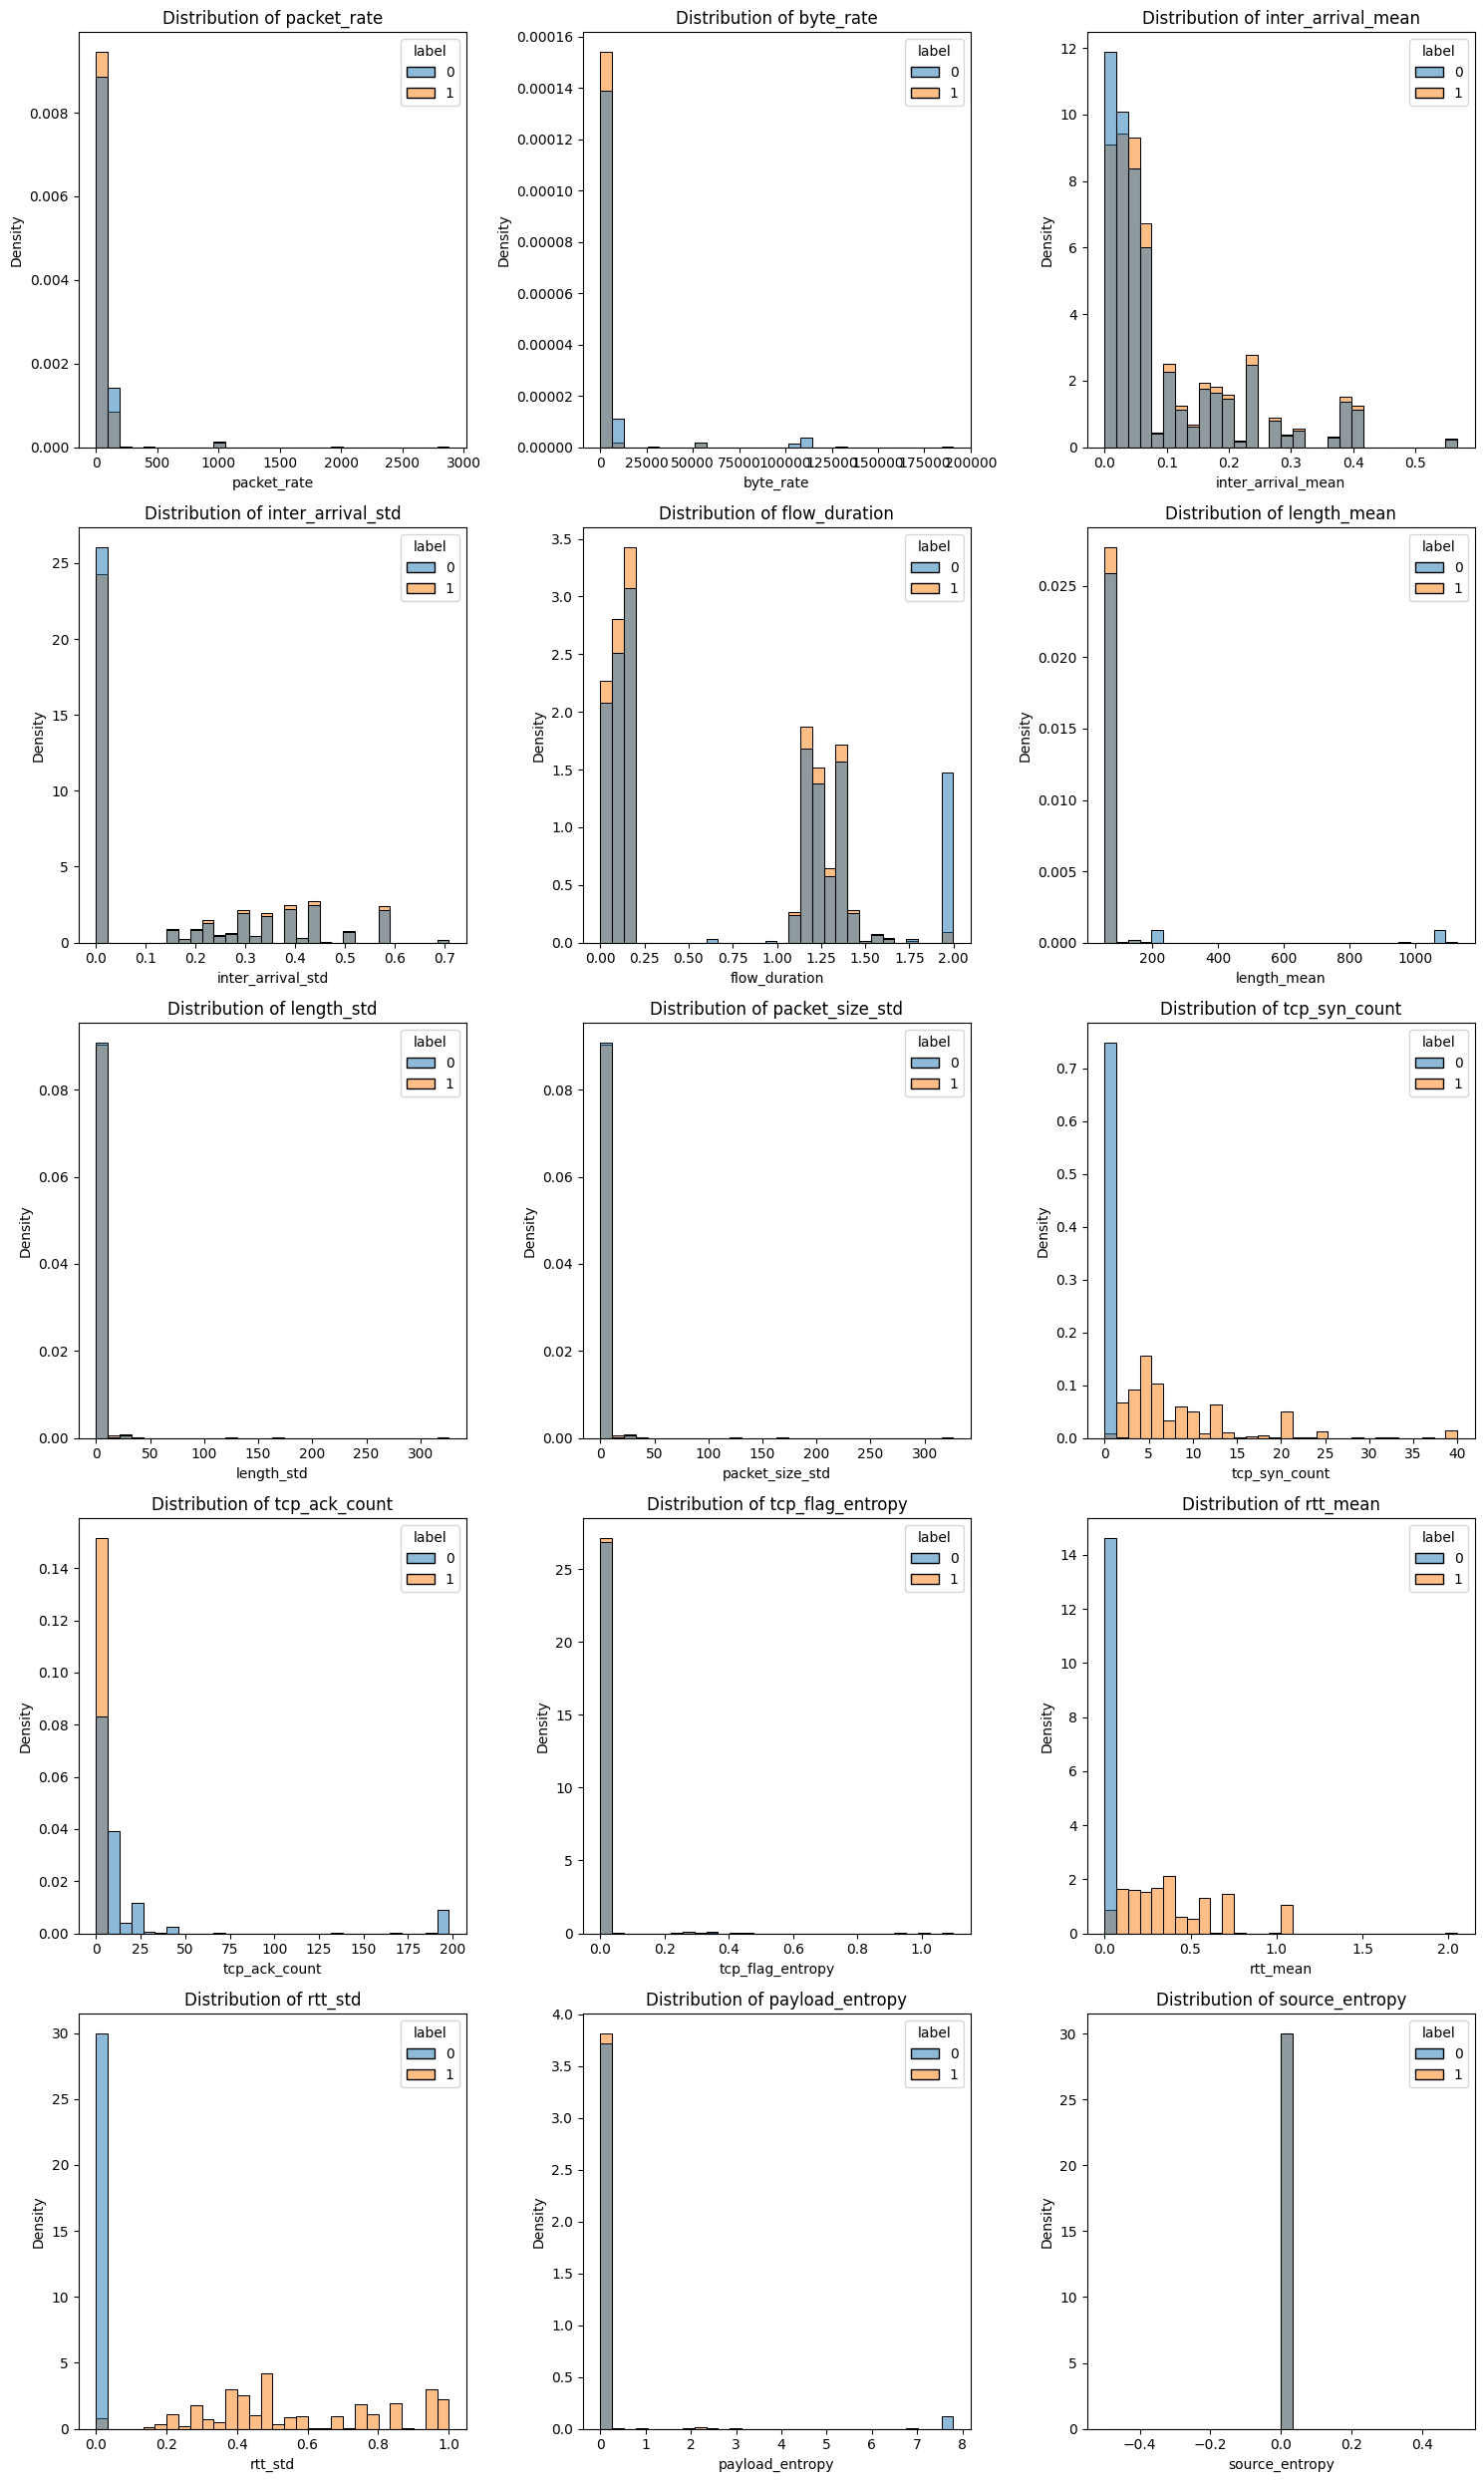

In [62]:
# Create DataFrame with features and labels
features = [
    'packet_rate', 'byte_rate', 'inter_arrival_mean', 'inter_arrival_std',
    'flow_duration', 'length_mean', 'length_std', 'packet_size_std',
    'tcp_syn_count', 'tcp_ack_count', 'tcp_flag_entropy', 'rtt_mean', 'rtt_std',
    'payload_entropy', 'source_entropy'
]
data_subset = data[features + ['label']]

# Plot histograms for each feature
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols
plt.figure(figsize=(15, 5 * n_rows))
for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=data_subset, x=feature, hue='label', bins=30, stat='density', common_norm=False)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Models/feature_distributions.png')
plt.show()
# Explanation:
# - Creates a DataFrame with features and labels.
# - Plots histograms for each feature, separated by class (normal vs. attack).
# - Uses density normalization for fair comparison, saves the plot to a file.

In [65]:
# Requirements: pip install torch kymatio scikit-learn pandas

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from kymatio.torch import Scattering1D

# 1. Load dataset
df = pd.read_csv("/content/drive/MyDrive/Datasets/4_metasploitable-2.csv")

# 2. Select relevant features
features = [
    'Flow Duration', 'Flow Byts/s', 'Flow Pkts/s',
    'Flow IAT Mean', 'Flow IAT Std',
    'Pkt Len Mean', 'Pkt Len Std',
    'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
    'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
    'SYN Flag Cnt', 'ACK Flag Cnt',
    'Active Mean', 'Idle Mean'
]
df = df[features + ['Label']].copy() # Add .copy() to avoid SettingWithCopyWarning
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Fill NaN values only in feature columns
df[features] = df[features].fillna(df[features].mean())

# 4. Convert Label to binary (DDoS=1, others=0)
df['Label'] = df['Label'].apply(lambda x: 1 if str(x).strip().lower() == 'ddos' else 0)

# Print label distribution to verify the encoding
print("Label distribution after binary encoding:")
print(df['Label'].value_counts())


# 5. Split features and labels
X = df[features].values
y = df['Label'].values

# Convert to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


# 6. Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert back to PyTorch tensors after standardization
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)


# 7. Scattering Transform
J, Q = 3, 8
scattering = Scattering1D(J=J, shape=X_train.shape[1], Q=Q)
X_train_scattering = scattering(X_train).view(X_train.size(0), 1, -1)
X_test_scattering = scattering(X_test).view(X_test.size(0), 1, -1)


# 8. Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        CE = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE)
        FL = self.alpha * (1 - pt) ** self.gamma * CE
        return FL.mean()

# 9. Gated TCN Block
class GatedConvBlock(nn.Module):
    def __init__(self, in_c, out_c, k):
        super().__init__()
        self.conv = nn.Conv1d(in_c, out_c, k, padding=k//2)
        self.gate = nn.Conv1d(in_c, out_c, k, padding=k//2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.relu(self.conv(x) * self.sigmoid(self.gate(x)))

# 10. GTCN Model
class LDOS_GTCN(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.conv1 = GatedConvBlock(1, 32, 3)
        self.conv2 = GatedConvBlock(32, 64, 3)
        self.pool = nn.MaxPool1d(2)
        self.flattened_size = 64 * (seq_len // 4)
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 2)
    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# 11. Train
model = LDOS_GTCN(seq_len=X_train_scattering.shape[2])
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = FocalLoss()
epochs = 5
batch_size = 32

for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_scattering), batch_size):
        inputs = X_train_scattering[i:i+batch_size]
        labels = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")


# 12. Evaluate
model.eval()
with torch.no_grad():
    out = model(X_test_scattering)
    preds = torch.argmax(out, dim=1)
    acc = (preds == y_test).float().mean()
    print(f"Test Accuracy: {acc.item() * 100:.2f}%")

# 13. Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/Models/gtcn_ldos_model_4.pth')

Label distribution after binary encoding:
Label
1    73529
0    63214
Name: count, dtype: int64
Epoch 1: Loss = 0.0004
Epoch 2: Loss = 0.0003
Epoch 3: Loss = 0.0003
Epoch 4: Loss = 0.0003
Epoch 5: Loss = 0.0003
Test Accuracy: 99.95%
